- **Author:** [Dace Apšvalka](https://www.mrc-cbu.cam.ac.uk/people/dace.apsvalka/) 
- **Date:** August 2024  
- **conda environment**: I used the [fMRI workshop's conda environment](https://github.com/MRC-CBU/COGNESTIC/blob/main/mri_environment.yml) to run this notebook and any accompanied scripts.

# fMRI Data Analysis: Group-Level Analysis

Once you have beta (or contrast) maps for conditions (or contrasts) from all subjects, you can perform group-level statistics. Group-level analysis allows you to make inferences about the population, rather than individual subjects, by assessing common patterns across participants. Common statistical methods for group-level analysis include one-sample or paired t-tests, as well as more complex mixed-effects models, depending on your study design.

In this tutorial, I am adopting a mixed-effects model approach. I will incorporate the beta maps of all nine conditions into a single design matrix with subject-specific regressors. This approach can capture more of the explained variance by accounting for both condition effects and subject-level variability in one model. This differs from a one-sample t-test on first-level contrast estimates, where the model only assesses the variance in the contrast across subjects. The one-sample t-test simplifies the analysis but doesn't explicitly model within-subject variability or interactions across conditions, which can lead to a less comprehensive understanding of the underlying effects. The mixed-effects model approach handles both within- and between-subject variability, allowing for a more nuanced analysis of comparisons and potentially reducing unexplained variance.

Mixed-effects models are often analysed with ANOVA, which Nilean's `second_level_model.compute_contrast` would do. However, there isn’t a straightforward way with Nilearn to check and account for non-sphericity in the data *(see Rik’s Stats tutorial on ANOVA for the importance of this)*. To mitigate this issue, we can use Nilearn's non-parametric inference, which I will employ for our final results in this group-level analysis example.

---------------

**Table of contents**<a id='toc0_'></a>    
1. [Import stuff](#toc1_)    
2. [Retrieving First-Level results](#toc2_)    
3. [Displaying subject Effects-Of-Interet z-maps](#toc3_)    
4. [Estimate second level model](#toc4_)    
4.1. [Design matrix](#toc4_1_)    
4.2. [Contrasts](#toc4_2_)    
4.3. [Model specification and fit](#toc4_3_)    
4.4. [Contrast estimation, thresholding and plotting](#toc4_4_)    
4.5. [Summary results](#toc4_5_)    
5. [Some more plotting options](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=3
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

-----
## 1. <a id='toc1_'></a>[Import required packages and set up some stuff](#toc0_)

In [1]:
import os.path as op # for file path operations
import glob # to search for files using regex

import pandas as pd # for data manipulation
import numpy as np # for numerical operations

from bids.layout import BIDSLayout # to fetch data from BIDS-compliant datasets

import matplotlib.pyplot as plt # for basic plotting

import nibabel as nib # NiBabel, to read and write neuroimaging data, https://nipy.org/nibabel/

# Nilearn, for the analysis of brain volumes, plotting, etc., https://nilearn.github.io/
from nilearn.plotting import plot_glass_brain, plot_design_matrix, plot_contrast_matrix, plot_stat_map, view_img, view_img_on_surf
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.datasets import load_mni152_template
from nilearn.glm.second_level import non_parametric_inference

from atlasreader import create_output # For generating result tables https://github.com/miykael/atlasreader

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



In [2]:
# MNI152 template will be used as a backgound for plotting MNI-space ROIs
mni152_template = load_mni152_template()

## 2. <a id='toc2_'></a>[Retrieve First-Level results](#toc0_)

In [3]:
# --- Set up the paths to the data and results folders
fmri_data_dir = '/imaging/correia/da05/workshops/Wakeman-ds/data' # data in BIDS format
fmri_results_dir = '/imaging/correia/da05/workshops/Wakeman-ds/results' # results in BIDS format

# --- Set up the BIDS layout
layout = BIDSLayout(fmri_data_dir, derivatives = True)

# Attach the results folder to the layout. It must complay with BIDS standards. 
# And must include dataset_description.json file!
layout.add_derivatives(op.join(fmri_results_dir, "first-level_fmriprep23"))

Specify which conditions to include in the analysis and retrieve their effect files from the first-level results.

In [4]:
conditions = ['FAMOUS1', 'FAMOUS2dl', 'FAMOUS2im', 'UNFAMILIAR1', 'UNFAMILIAR2dl', 'UNFAMILIAR2im', 'SCRAMBLED1', 'SCRAMBLED2dl', 'SCRAMBLED2im']
effect_files = layout.get(desc=conditions, suffix='effect', extension='.nii.gz', return_type='filename')

# print to see if it found what we expexted
print(f"Found {len(effect_files)} effect files:")
print(*effect_files, sep="\n")

Found 144 effect files:
/imaging/correia/da05/workshops/Wakeman-ds/results/first-level_fmriprep23/sub-01/sub-01_task-faceprocessing_desc-FAMOUS1_effect.nii.gz
/imaging/correia/da05/workshops/Wakeman-ds/results/first-level_fmriprep23/sub-01/sub-01_task-faceprocessing_desc-FAMOUS2dl_effect.nii.gz
/imaging/correia/da05/workshops/Wakeman-ds/results/first-level_fmriprep23/sub-01/sub-01_task-faceprocessing_desc-FAMOUS2im_effect.nii.gz
/imaging/correia/da05/workshops/Wakeman-ds/results/first-level_fmriprep23/sub-01/sub-01_task-faceprocessing_desc-SCRAMBLED1_effect.nii.gz
/imaging/correia/da05/workshops/Wakeman-ds/results/first-level_fmriprep23/sub-01/sub-01_task-faceprocessing_desc-SCRAMBLED2dl_effect.nii.gz
/imaging/correia/da05/workshops/Wakeman-ds/results/first-level_fmriprep23/sub-01/sub-01_task-faceprocessing_desc-SCRAMBLED2im_effect.nii.gz
/imaging/correia/da05/workshops/Wakeman-ds/results/first-level_fmriprep23/sub-01/sub-01_task-faceprocessing_desc-UNFAMILIAR1_effect.nii.gz
/imaging/c

## 3. <a id='toc3_'></a>[Displaying subject Effects-Of-Interet z-maps](#toc0_)

To check how the first-level results look overall, it is helpful to display effects-of-interest for all subjects. 

In [5]:
eoi_maps = layout.get(desc='EffectsOfInterest', extension='.nii.gz', return_type='file')
print(*eoi_maps, sep="\n")

/imaging/correia/da05/workshops/Wakeman-ds/results/first-level_fmriprep23/sub-01/sub-01_task-faceprocessing_desc-EffectsOfInterest_z.nii.gz
/imaging/correia/da05/workshops/Wakeman-ds/results/first-level_fmriprep23/sub-02/sub-02_task-faceprocessing_desc-EffectsOfInterest_z.nii.gz
/imaging/correia/da05/workshops/Wakeman-ds/results/first-level_fmriprep23/sub-03/sub-03_task-faceprocessing_desc-EffectsOfInterest_z.nii.gz
/imaging/correia/da05/workshops/Wakeman-ds/results/first-level_fmriprep23/sub-04/sub-04_task-faceprocessing_desc-EffectsOfInterest_z.nii.gz
/imaging/correia/da05/workshops/Wakeman-ds/results/first-level_fmriprep23/sub-05/sub-05_task-faceprocessing_desc-EffectsOfInterest_z.nii.gz
/imaging/correia/da05/workshops/Wakeman-ds/results/first-level_fmriprep23/sub-06/sub-06_task-faceprocessing_desc-EffectsOfInterest_z.nii.gz
/imaging/correia/da05/workshops/Wakeman-ds/results/first-level_fmriprep23/sub-07/sub-07_task-faceprocessing_desc-EffectsOfInterest_z.nii.gz
/imaging/correia/da0

Text(0.5, 0.98, 'Effects of interest, unthresholded z-maps')

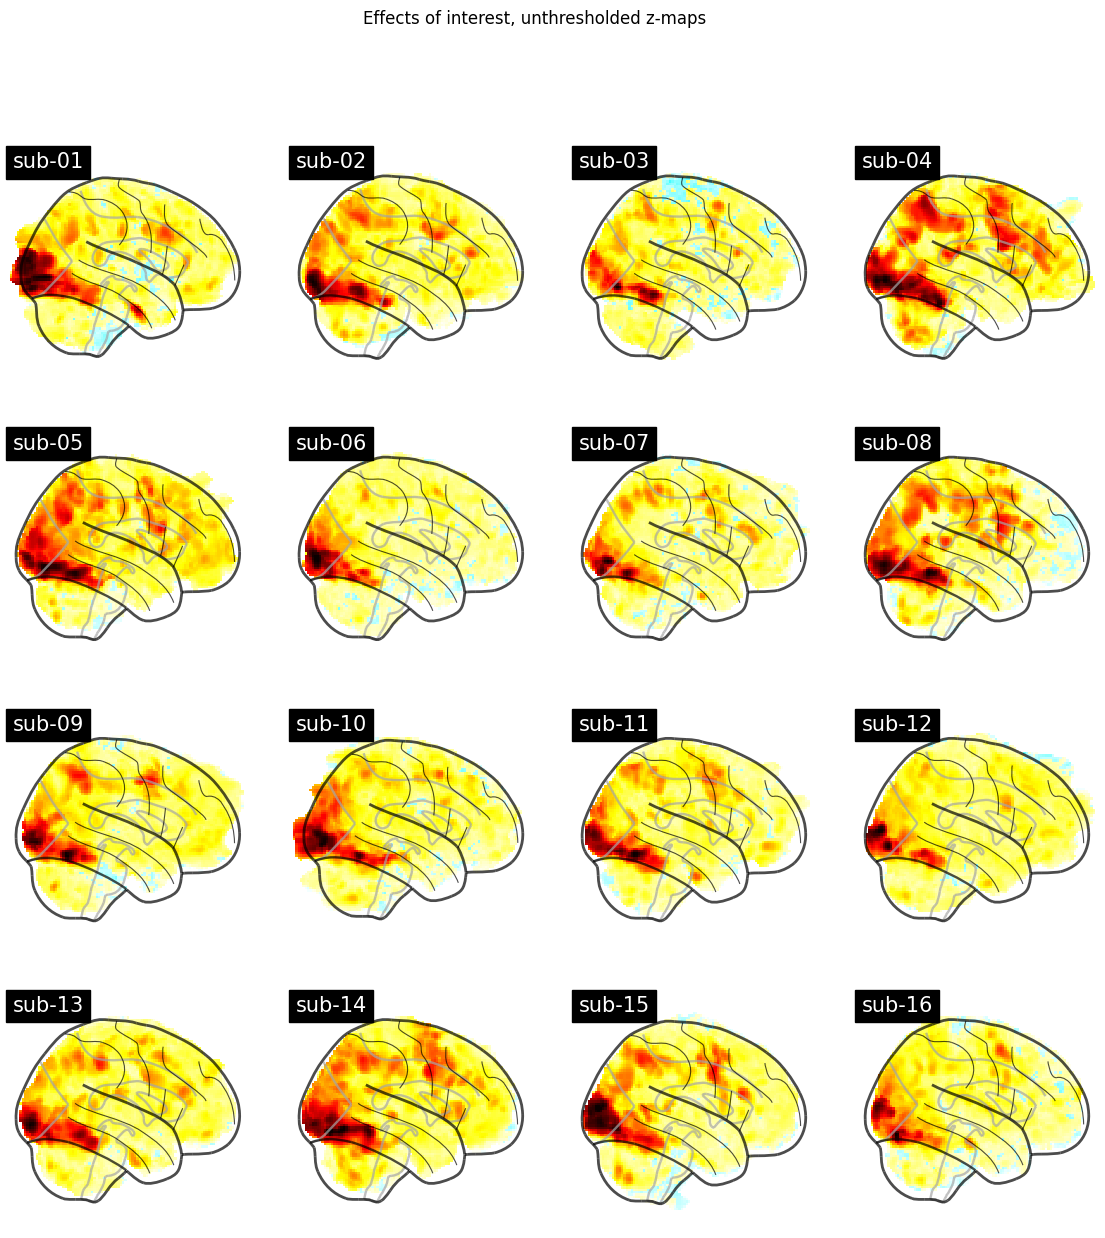

In [6]:
subjects = layout.get_subjects()

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 14))

for i, stat_map in enumerate(eoi_maps):
    plot_glass_brain(stat_map, 
                              title = 'sub-' + subjects[i],
                              axes = axes[int(i / 4), int(i % 4)],
                              plot_abs = False, 
                              display_mode='x')
fig.suptitle('Effects of interest' + ', unthresholded z-maps')

## 4. <a id='toc4_'></a>[Specify the second-level model](#toc0_)

### 4.1. <a id='toc4_1_'></a>[Design matrix](#toc0_)

The number of rows in the design matrix must match the number of maps that will be entered into the second-level model. The order of the rows in the design matrix must match the order of the provided maps.

In [7]:
conditions = ['FAMOUS1', 'FAMOUS2dl', 'FAMOUS2im', 'UNFAMILIAR1', 'UNFAMILIAR2dl', 'UNFAMILIAR2im', 'SCRAMBLED1', 'SCRAMBLED2dl', 'SCRAMBLED2im']
# Create an empty DataFrame
df = pd.DataFrame(columns=conditions + subjects)

# Populate the DataFrame with 0s and 1s
for i, condition in enumerate(conditions):
    # Filter files based on condition
    condition_files = [1 if condition in file else 0 for file in effect_files]
    # Add a column for the condition
    df[condition] = condition_files

# Populate the DataFrame with 0s and 1s for subjects
for i, subject in enumerate(subjects):
    # Filter files based on subject
    subject_files = [1 if f"sub-{subject}" in file else 0 for file in effect_files]
    # Add a column for the subject
    df[subject] = subject_files

# Print the resulting DataFrame
design_matrix = df
design_matrix

FAMOUS1  FAMOUS2dl  FAMOUS2im  UNFAMILIAR1  UNFAMILIAR2dl  UNFAMILIAR2im  \
0          1          0          0            0              0              0   
1          0          1          0            0              0              0   
2          0          0          1            0              0              0   
3          0          0          0            0              0              0   
4          0          0          0            0              0              0   
..       ...        ...        ...          ...            ...            ...   
139        0          0          0            0              0              0   
140        0          0          0            0              0              0   
141        0          0          0            1              0              0   
142        0          0          0            0              1              0   
143        0          0          0            0              0              1   

     SCRAMBLED1  SCRAMBLED2dl  SCRAMBLED2im  01  ...  07  08  09  10  11  12  \
0             0             0             0   1  ...   0   0   0   0   0   0   
1             0             0             0   1  ...   0   0   0   0   0   0   
2             0             0             0   1  ...   0   0   0   0   0   0   
3             1             0             0   1  ...   0   0   0   0   0   0   
4             0             1             0   1  ...   0   0   0   0   0   0   
..          ...           ...           ...  ..  ...  ..  ..  ..  ..  ..  ..   
139           0             1             0   0  ...   0   0   0   0   0   0   
140           0             0             1   0  ...   0   0   0   0   0   0   
141           0             0             0   0  ...   0   0   0   0   0   0   
142           0             0             0   0  ...   0   0   0   0   0   0   
143           0             0             0   0  ...   0   0   0   0   0   0   

     13  14  15  16  
0     0   0   0   0  
1     0   0   0   0  
2     0   0   0   0  
3     0   0   0   0  
4     0   0   0   0  
..   ..  ..  ..  ..  
139   0   0   0   1  
140   0   0   0   1  
141   0   0   0   1  
142   0   0   0   1  
143   0   0   0   1  

[144 rows x 25 columns]

Text(42.722222222222214, 0.5, 'stat maps')

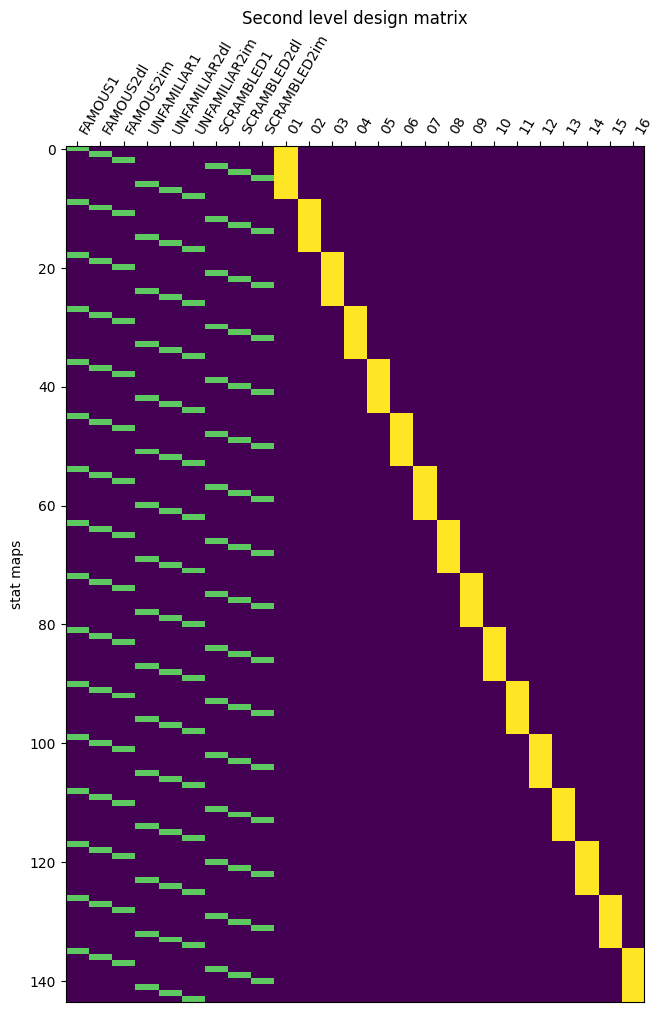

In [8]:
ax = plot_design_matrix(design_matrix)
ax.set_title("Second level design matrix", fontsize=12)
ax.set_ylabel("stat maps")

### 4.2. <a id='toc4_2_'></a>[Contrasts](#toc0_)

For these group-level results, we are only interested in the statistics, not the contrast estimates, so scaling the contrasts is not strictly necessary.

In [9]:
n_columns = design_matrix.shape[1]

contrasts = {
  'Faces_Scrambled': np.pad([1, 1, 1, 1, 1, 1, -2, -2, -2], (0, n_columns - 9), 'constant'),
  'Famous_Unfamiliar': np.pad([1, 1, 1, -1, -1, -1, 0, 0, 0], (0, n_columns - 9), 'constant'),
  'EffectsOfInterest': np.eye(n_columns)[:9] 
}


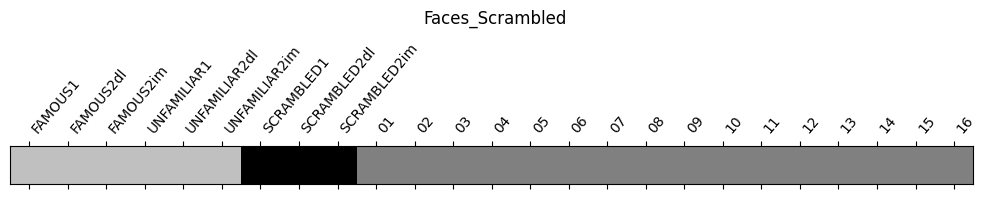

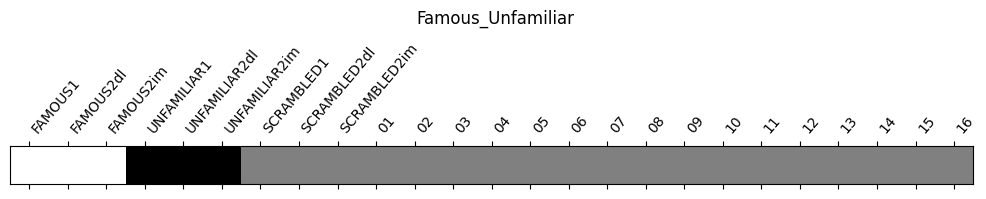

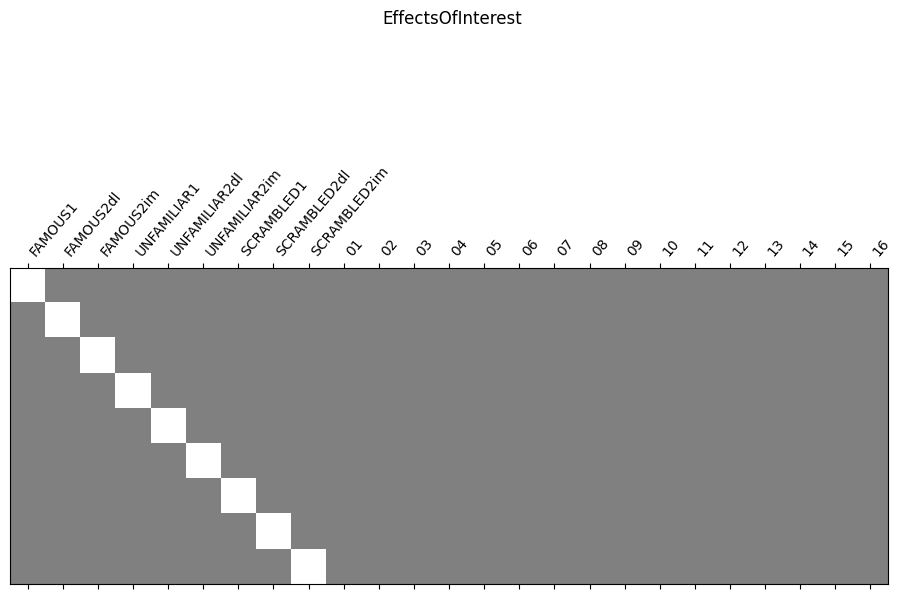

In [10]:
for contrast_id, contrast_val in contrasts.items():
    plot_contrast_matrix(contrast_val, design_matrix=design_matrix)
    plt.suptitle(contrast_id)

### 4.3. <a id='toc4_3_'></a>[Model specification and fit](#toc0_)

In [11]:
second_level_model = SecondLevelModel(smoothing_fwhm = None) 
second_level_model = second_level_model.fit(effect_files, design_matrix = design_matrix) # RM ANOVA, based on the design matrix

### 4.4. <a id='toc4_4_'></a>[Contrast estimation, thresholding and plotting](#toc0_)

#### p < .001 uncorrected (false positive rate)

In [12]:
z_map = second_level_model.compute_contrast(contrasts['Faces_Scrambled'], output_type='z_score')

_, threshold = threshold_stats_img(
  z_map, 
  alpha=0.001, 
  height_control='fpr', 
  cluster_threshold=5,
  two_sided=True)


Uncorrected p<.001 threshold: 3.291


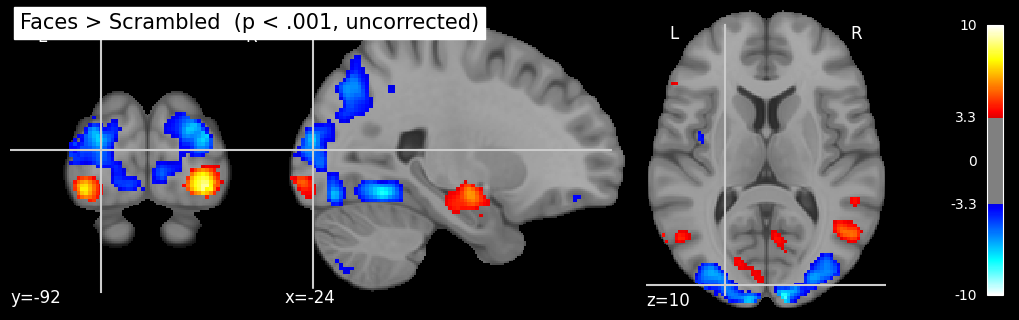

In [13]:
print('Uncorrected p<.001 threshold: %.3f' % threshold)

plot_stat_map(
    z_map, 
    threshold = threshold,       
    display_mode = 'ortho',
    black_bg = True,
    bg_img = mni152_template,
    title = 'Faces > Scrambled  (p < .001, uncorrected)'
    )

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

/imaging/correia/da05/conda/env/mri/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



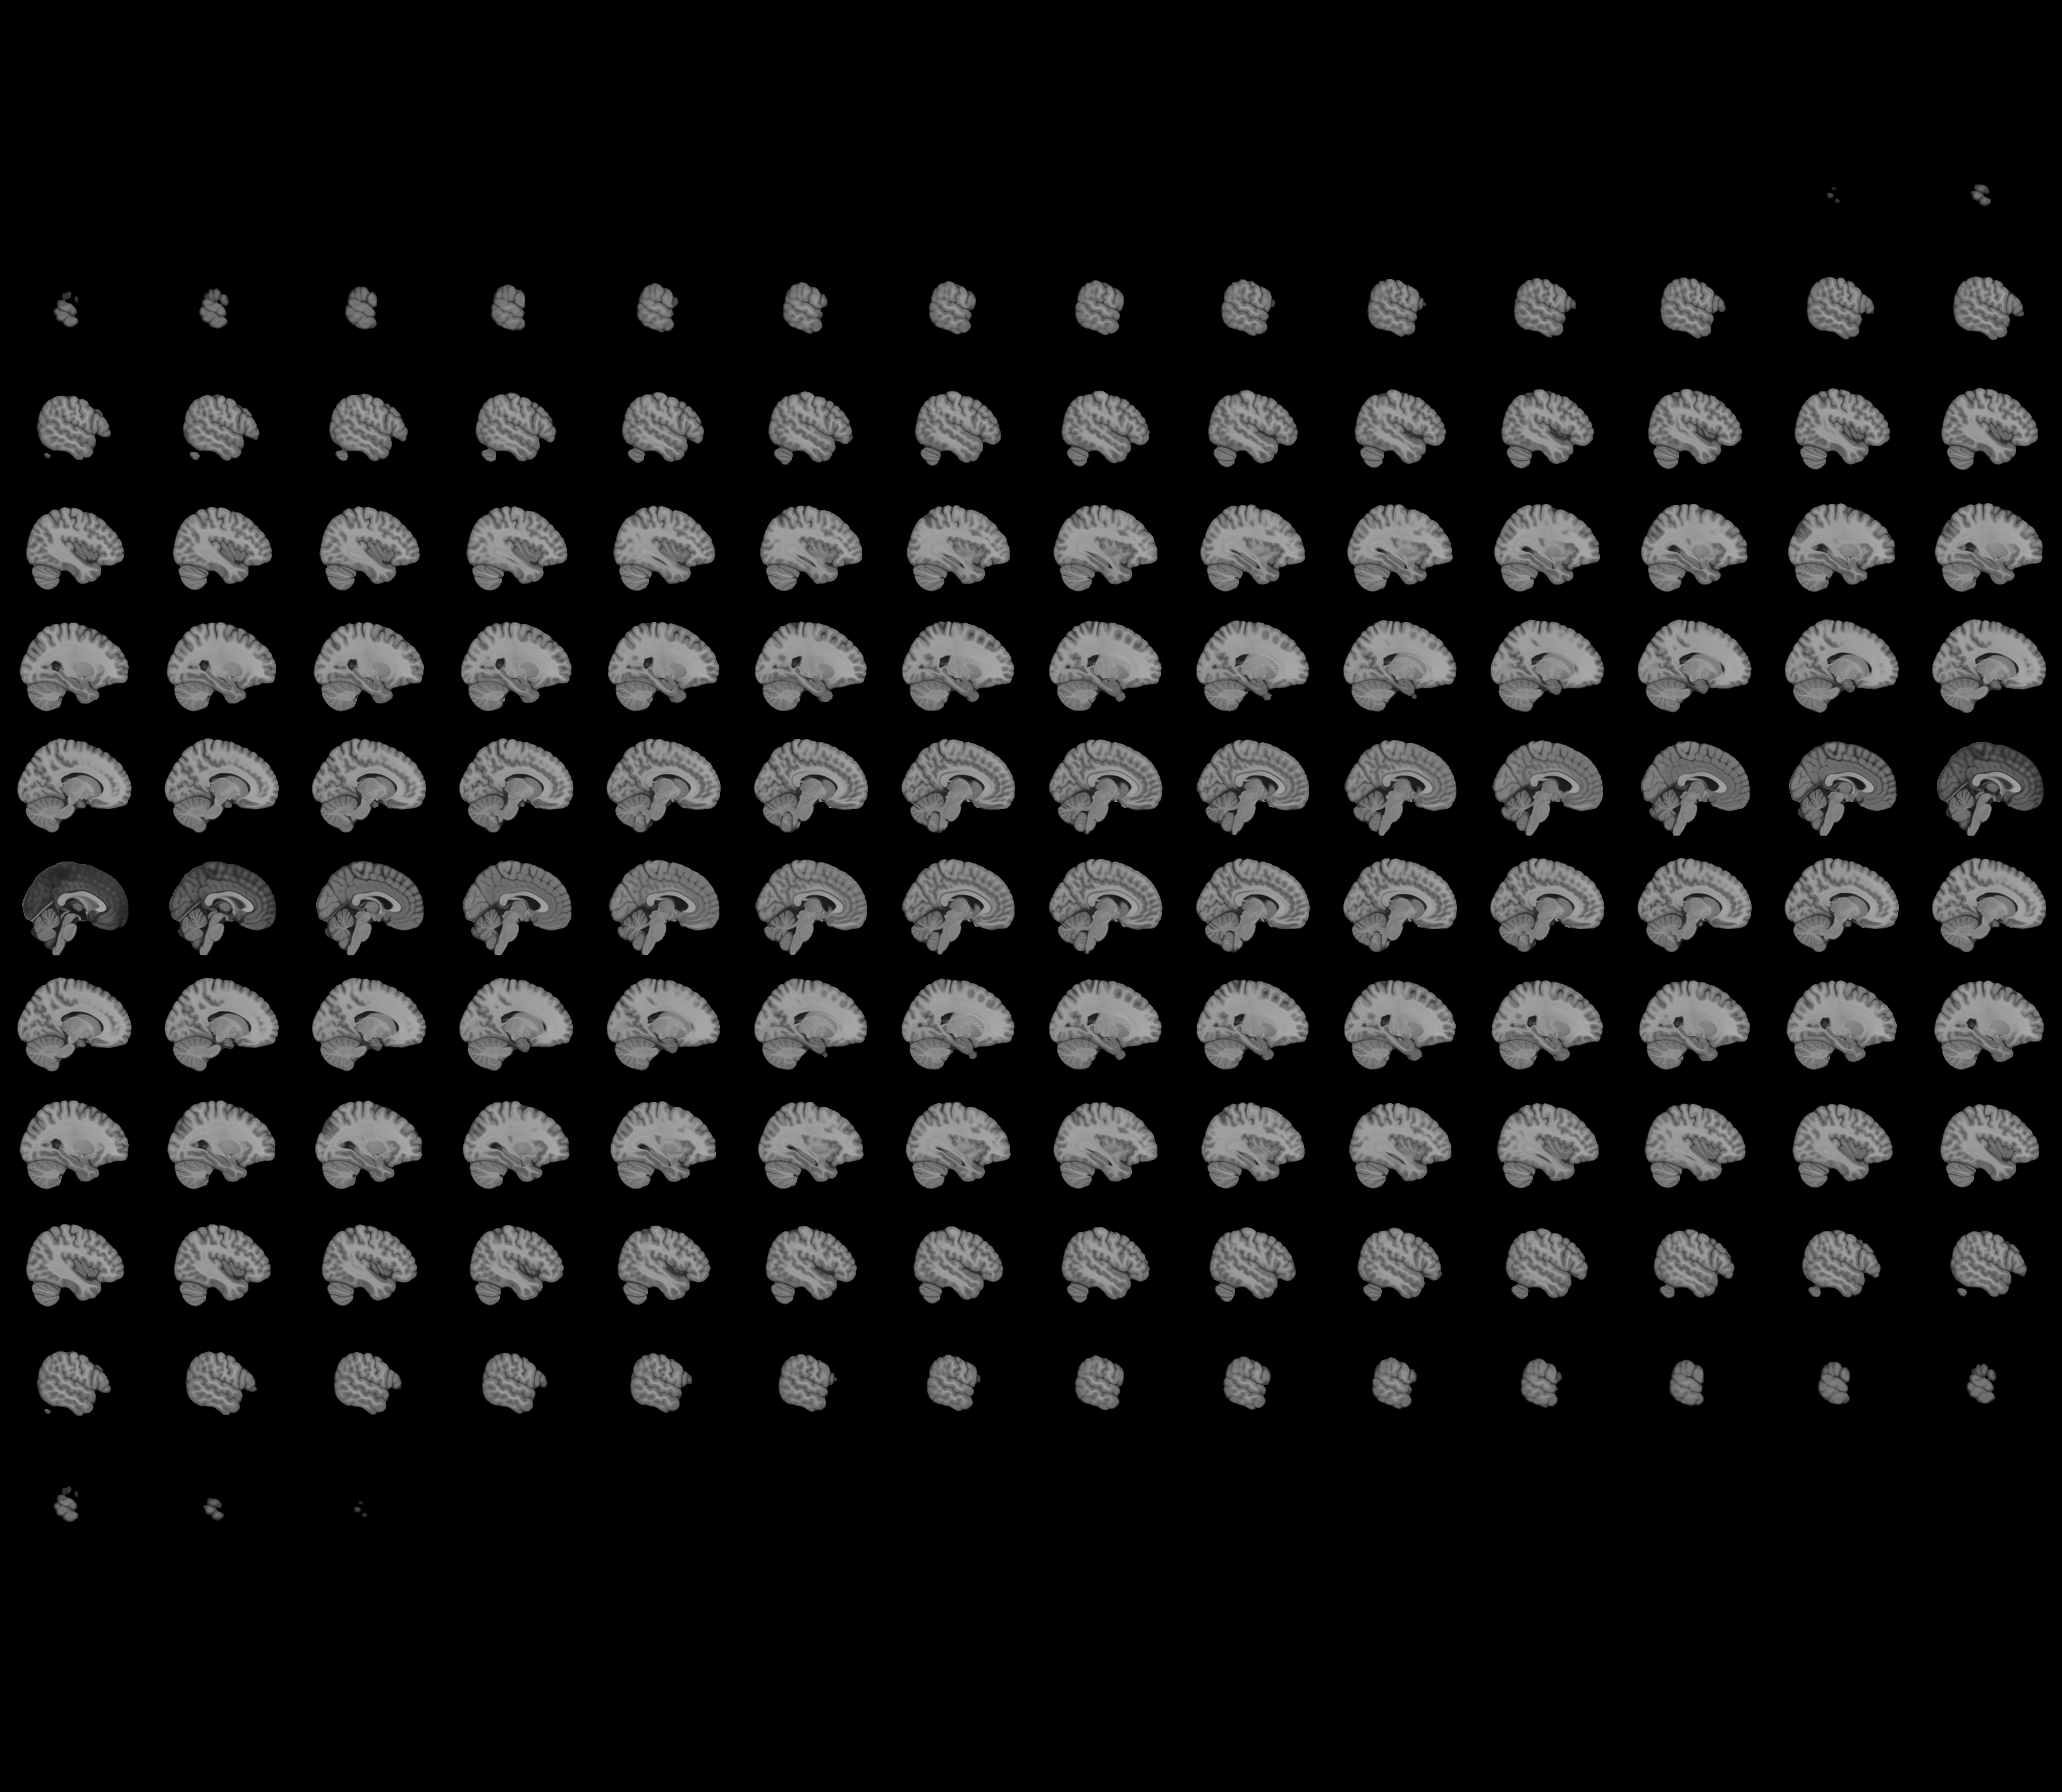
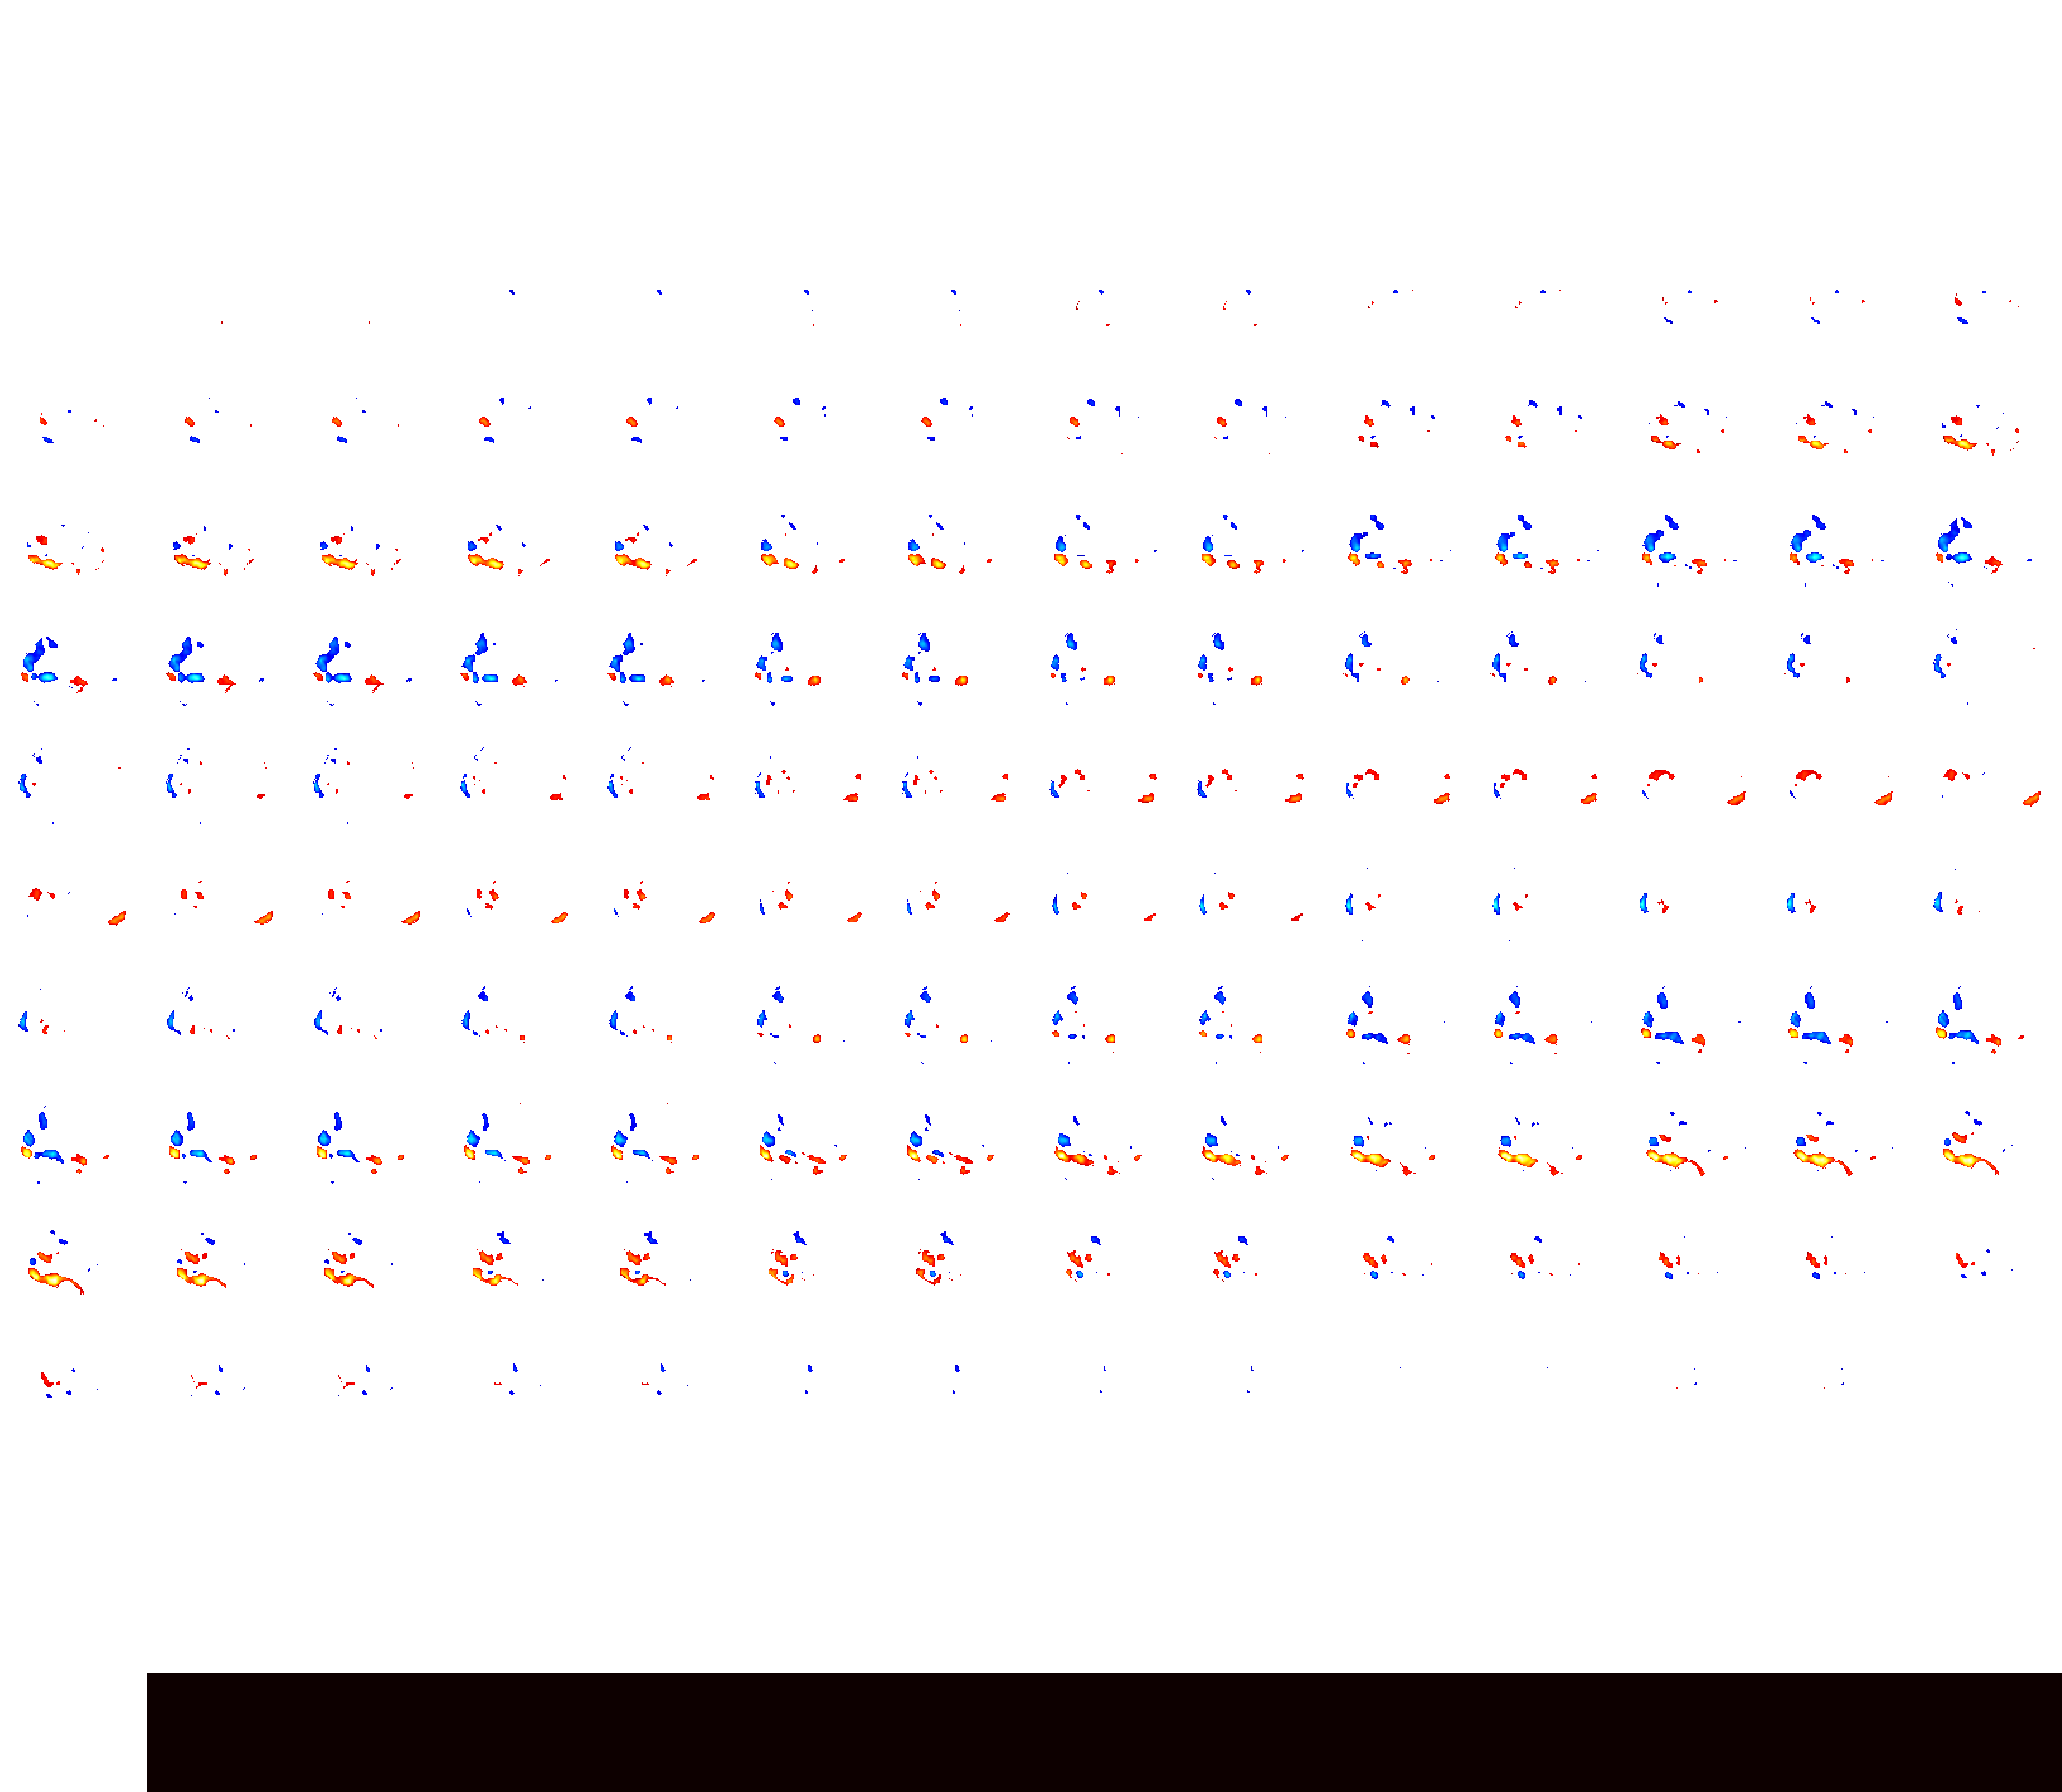

In [14]:
# Interactive plotting
view_img(
  z_map, 
  bg_img=mni152_template, 
  threshold=threshold, 
  colorbar=True, 
  title='Faces > Scrambled  (p < .001, uncorrected)'
  )

#plot.open_in_browser()

#### Permutation test, voxel-level error control

In [15]:
out_dict = non_parametric_inference(
    effect_files,
    design_matrix = design_matrix,
    second_level_contrast = contrasts['Faces_Scrambled'],
    n_perm = 10000, 
    two_sided_test = False,
    n_jobs = -1, # Use all available cores
    threshold = 0.001 # cluster level threshold; enables cluster-level inference
)

# Print the keys of the output dictionary
print(out_dict.keys())

/imaging/correia/da05/conda/env/mri/lib/python3.11/site-packages/nilearn/mass_univariate/permuted_least_squares.py:986: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/imaging/correia/da05/conda/env/mri/lib/python3.11/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


dict_keys(['t', 'logp_max_t', 'size', 'logp_max_size', 'mass', 'logp_max_mass'])


The output is multiple images (maps), organised in a dictionary. 
* Voxel-level inference
  * *t*: t-statistics
  * *logp_max_t*: Negative log10 family-wise error rate-corrected p-values corrected based on the distribution of maximum t-statistics from permutations.
* Cluster-level inference
  * *size*: Cluster size values associated with the significance test 
  * *logp_max_size*: Negative log10 family-wise error rate-corrected p-values corrected based on the distribution of maximum cluster sizes from permutations.
  * *mass*: Cluster mass values associated with the significance test 
  * *logp_max_mass*: Negative log10 family-wise error rate-corrected p-values corrected based on the distribution of maximum cluster masses from permutations. 

Here we will focus only on the voxel-level inference. 

To report the FWE-corrected maps, we could display the *logp_max_t*; however, these values can be difficult to interpret if you're not familiar with them. It might be better to plot and report a t-map, masked to exclude the voxels that did not survive the FWE correction.

Let's create a new image displaying t-values for the voxels with a p-value < 0.05.

In [16]:
alpha = 0.05
masked = out_dict['logp_max_t'].get_fdata() > -np.log10(alpha)
masked_t_map = out_dict['t'].get_fdata() * masked

# save the masked t-map as a nifti image
masked_t_map_img = nib.Nifti1Image(masked_t_map, out_dict['t'].affine)

4.933279731378906


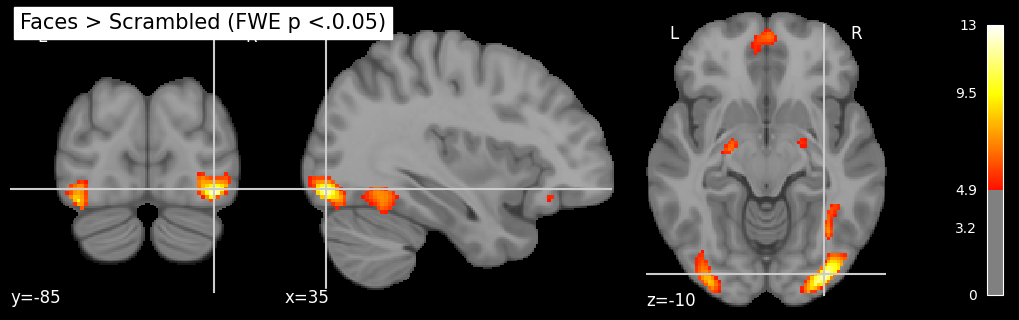

In [17]:
# Get the smallest t-value that is above the threshold (for the colorbar; the maps themselves are thresholded already)
t_threshold = masked_t_map[masked_t_map > 0].min()
print(t_threshold)

plot_stat_map(
    masked_t_map_img, 
    threshold = t_threshold,       
    display_mode = 'ortho',
    black_bg = True,
    bg_img = mni152_template,
    cmap = 'hot',
    title = f"Faces > Scrambled (FWE p <.{alpha})")

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

### 4.5. <a id='toc4_5_'></a>[Summary results](#toc0_)

We can use ['atlasreader'](https://github.com/miykael/atlasreader) package to get summary results (peak table, cluster table, .png images of each cluster). 

In [18]:
# generate and save atlasreader output
outdir = op.join(fmri_results_dir, 'group-level23', 'permutation', 'FacesScrambled')

create_output(
    masked_t_map_img, 
    cluster_extent = 20, 
    voxel_thresh = t_threshold,
    direction = 'pos',
    outdir = outdir
)

#### Peak table for Faces > Scrambled (FWE p<.05)

In [19]:
# display the peak table
peaks = glob.glob(op.join(outdir, '*_peaks.csv'))
display(pd.read_csv(peaks[0]))

cluster_id  peak_x  peak_y  peak_z  peak_value  volume_mm  \
0         1.0    35.5   -86.5   -12.5   12.636959     8496.0   
1         2.0   -36.5   -86.5   -16.5    9.493114     5016.0   
2         3.0     1.5    57.5   -10.5    6.713810     1656.0   
3         4.0    43.5   -62.5    15.5    6.278364     1088.0   
4         5.0    21.5    -6.5   -16.5    8.116887     1072.0   
5         6.0   -20.5    -8.5   -14.5    8.640182      744.0   
6         7.0   -52.5   -68.5    17.5    6.234207      552.0   
7         8.0   -32.5    -6.5   -18.5    6.175189      288.0   

                 aal             desikan_killiany  \
0    Occipital_Inf_R  Right-Cerebral-White-Matter   
1          Lingual_L   Left-Cerebral-White-Matter   
2  Frontal_Med_Orb_L                      Unknown   
3     Temporal_Mid_R      ctx-rh-inferiorparietal   
4      Hippocampus_R               Right-Amygdala   
5      Hippocampus_L                Left-Amygdala   
6     Temporal_Mid_L      ctx-lh-lateraloccipital   
7           no_label   Left-Cerebral-White-Matter   

                                      harvard_oxford  
0  44.0% Right_Lateral_Occipital_Cortex_inferior_...  
1  54.0% Left_Lateral_Occipital_Cortex_inferior_d...  
2  64.0% Right_Frontal_Pole; 17.0% Right_Frontal_...  
3  36.0% Right_Lateral_Occipital_Cortex_superior_...  
4       90.0% Right_Amygdala; 5.0% Right_Hippocampus  
5                                94.0% Left_Amygdala  
6  69.0% Left_Lateral_Occipital_Cortex_superior_d...  
7         18.0% Left_Amygdala; 6.0% Left_Hippocampus

In [20]:
# display the cluster table
clusters = glob.glob(op.join(outdir, '*_clusters.csv'))
display(pd.read_csv(clusters[0]))

cluster_id  peak_x  peak_y  peak_z  cluster_mean  volume_mm  \
0         1.0    35.5   -86.5   -12.5      7.043507     8496.0   
1         2.0   -36.5   -86.5   -16.5      6.389186     5016.0   
2         3.0     1.5    57.5   -10.5      5.562437     1656.0   
3         4.0    43.5   -62.5    15.5      5.360705     1088.0   
4         5.0    21.5    -6.5   -16.5      5.871698     1072.0   
5         6.0   -20.5    -8.5   -14.5      6.104199      744.0   
6         7.0   -52.5   -68.5    17.5      5.478246      552.0   
7         8.0   -32.5    -6.5   -18.5      5.402871      288.0   

                                                 aal  \
0  47.27% Occipital_Inf_R; 34.27% Fusiform_R; 7.9...   
1  54.86% Fusiform_L; 26.48% Occipital_Inf_L; 5.2...   
2  46.38% Frontal_Med_Orb_L; 20.77% Frontal_Med_O...   
3                              95.59% Temporal_Mid_R   
4  50.00% Hippocampus_R; 42.54% Amygdala_R; 7.46%...   
5  52.69% Hippocampus_L; 31.18% Amygdala_L; 16.13...   
6                              98.55% Temporal_Mid_L   
7  44.44% Hippocampus_L; 36.11% no_label; 19.44% ...   

                                    desikan_killiany  \
0  47.18% Right-Cerebral-White-Matter; 21.09% ctx...   
1  34.29% Left-Cerebral-White-Matter; 23.29% ctx-...   
2  67.15% Unknown; 19.81% ctx-lh-medialorbitofron...   
3  27.21% Right-Cerebral-White-Matter; 25.00% ctx...   
4  67.16% Right-Amygdala; 18.66% Right-Hippocampu...   
5  49.46% Left-Amygdala; 24.73% Left-Hippocampus;...   
6  37.68% Unknown; 31.88% ctx-lh-lateraloccipital...   
7  41.67% Left-Cerebral-White-Matter; 30.56% Left...   

                                      harvard_oxford  
0  34.93% Right_Temporal_Occipital_Fusiform_Corte...  
1  36.84% Left_Temporal_Occipital_Fusiform_Cortex...  
2  43.00% Left_Frontal_Medial_Cortex; 27.05% Righ...  
3  50.00% Right_Lateral_Occipital_Cortex_superior...  
4    82.84% Right_Amygdala; 17.16% Right_Hippocampus  
5      81.72% Left_Amygdala; 17.20% Left_Hippocampus  
6  84.06% Left_Lateral_Occipital_Cortex_superior_...  
7      66.67% Left_Amygdala; 33.33% Left_Hippocampus

## 5. <a id='toc5_'></a>[Some more plotting options](#toc0_)

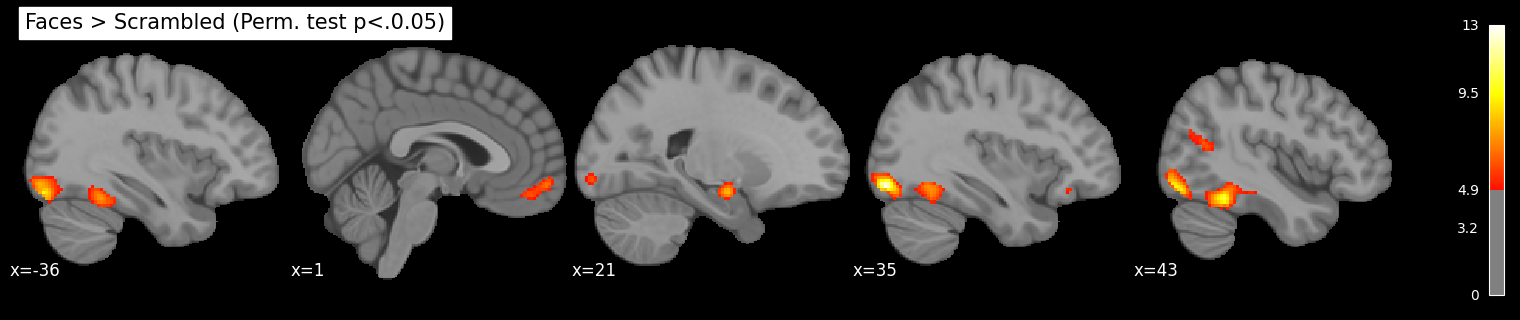

In [21]:
# get the top 5 peaks' x values
x = pd.read_csv(peaks[0])['peak_x'][:5]
# sort the x values
x = x.sort_values()

# plot these peaks
plot_stat_map(
    masked_t_map_img, 
    threshold = t_threshold,       
    display_mode = 'x',
    cut_coords = x,
    black_bg = True,
    bg_img = mni152_template,
    cmap = 'hot',
    title = f"Faces > Scrambled (Perm. test p<.{alpha})")

fig = plt.gcf()
fig.set_size_inches(15,3)

We can also look at a 3D brain using `plotly`.

In [22]:
view = view_img_on_surf(masked_t_map_img, 
    threshold = t_threshold)
#view.open_in_browser()
view.resize(1600, 800)
view

Or use, for example, FSLeyes

We don't always need to do a whole brain analysis. We can have hypothesis for specific brain regions. In that case, we can perform **Region-Of-Interest** (ROI) analysis. See the next notebook for some examples. 